 Written by Abdennour Harche
 
 February 2024

In [13]:
from qiskit import QuantumRegister,ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np
from collections import Counter
from fractions import Fraction

In [3]:
def adder(n,a) -> QuantumCircuit:
    qc= QuantumCircuit(n)
    for i in range(n):
        phi = np.divide(2 * np.pi * a , 2**(i+1))
        qc.rz(phi, n-i-1)
    qc.name = 'ADD'
    return qc

def subtract(n,a) -> QuantumCircuit:
    qc= QuantumCircuit(n)
    for i in range(n):
        phi = np.divide(2 * np.pi * a , 2**(i+1))
        qc.rz(-phi, n-i-1)
    qc.name = 'SUB'
    return qc

def modular_adder(n,a,N) -> QuantumCircuit:
    qc= QuantumCircuit(n+2)
    qc.append(adder(n+1,a),range(n+1))
    qc.append(subtract(n+1,N), range(n+1))
    qft = QFT(n+1)
    qftdagger = QFT(n+1,inverse=True)
    qc.append(qftdagger,range(n+1))
    qc.cx(n,n+1)
    qc.append(qft,range(n+1))
    qq = [-1]
    qq.extend(range(n+1))
    qc.append(adder(n+1,N).control(),qq)
    qc.append(subtract(n+1,a),range(n+1))
    qc.append(qftdagger,range(n+1))
    qc.x(n)
    qc.cx(n,n+1)
    qc.x(n)
    qc.append(qft,range(n+1))
    qc.append(adder(n+1,a),range(n+1))
    qc.name = 'MA'
    return qc

def multiplier(n,a,N) -> QuantumCircuit:
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    qc = QuantumCircuit(qrx,qrb,qra)
    qft = QFT(n+1)
    qftdagger = QFT(n+1,inverse=True)
    qc.append(qft,qrb)
    for i in range(n):
        qs = [i]
        qs.extend(range(n,2*n+2))
        qc = qc.compose(modular_adder(n,2**(i) * a,N).decompose().control(), qs)
    qc.append(qftdagger,qrb)
    qc.name = 'MIL'
    return qc

def swapper(n) -> QuantumCircuit:
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')

    qc = QuantumCircuit(qrx,qrb)

    for i in range(n):
        qc.swap(i, n+i)
    qc.name='SWAPPER'
    return qc

def imultiplier(n,a,N) -> QuantumCircuit:
    qc = multiplier(n,a,N).inverse()
    return qc

def modular_exponent(n,a,N) -> QuantumCircuit:
    qrp = QuantumRegister(1, '\phi')
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')

    qc = QuantumCircuit(qrp,qrx,qrb,qra)
    qc = qc.compose(multiplier(n,a,N).decompose().control(), range(2*n+3))
    qc = qc.compose(swapper(n).control(), range(2*n+2))
    qc = qc.compose(imultiplier(n,1/a,N).decompose().control(), range(2*n+3))
    qc.name='modexp'
    return qc

def shor(n,a,N) -> QuantumCircuit:
    qrp = QuantumRegister(2*n, '\phi')
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    mes = ClassicalRegister(2*n,'M')

    qftdagger = QFT(2*n,inverse=True)

    qc = QuantumCircuit(qrp,qrx,qrb,qra,mes)
    
    qc.h(qrp)
    qc.x(qrx[0])
    for i in range(2*n):
        qq = [i]
        qq.extend(range(2*n, 4*n+2))
        qc.append(modular_exponent(n,(a**(2**i))%N,N), qq)
    
    qc = qc.compose(qftdagger, qrp)
    qc.measure(qrp,mes)
    return qc

In [4]:
simulator = Aer.get_backend('aer_simulator')

In [25]:
def aplusb(n,a,b) -> QuantumCircuit:
    qft = QFT(n)
    qftdagger = QFT(n,inverse=True)
    bb = bin(b)[::-1]
    qc = QuantumCircuit(n)

    for i in range(len(bb)):
        if bb[i]=='1': qc.x(i)

    qc.append(qft,range(n))
    qc.append(adder(n,a),range(n))
    qc.append(qftdagger, range(n))
    qc.measure_all()
    return qc

def bminusa(n,a,b) -> QuantumCircuit:
    qft = QFT(n)
    qftdagger = QFT(n,inverse=True)
    bb = bin(b)[::-1]
    qc = QuantumCircuit(n)

    for i in range(len(bb)):
        if bb[i]=='1': qc.x(i)

    qc.append(qft,range(n))
    qc.append(subtract(n,a),range(n))
    qc.append(qftdagger, range(n))
    qc.measure_all()
    return qc

def aplusbmodN(n,a,b,N) -> QuantumCircuit:
    qft = QFT(n+1)
    qftdagger = QFT(n+1,inverse=True)
    
    bb = bin(b)[::-1]
    qc = QuantumCircuit(n+2)
    
    for i in range(len(bb)):
        if bb[i]=='1': qc.x(i)
    qc.append(qft,range(n+1))
    qc.append(modular_adder(n,a,N), range(n+2))
    qc.append(qftdagger, range(n+1))
    qc.measure_all()
    return qc

def axplusbmodN(n,a,x,b,N)  -> QuantumCircuit:
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    mes = ClassicalRegister(n+1,'M')
    qc = QuantumCircuit(qrx,qrb,qra,mes)

    bb = bin(b)[::-1]
    for i in range(n, n + len(bb)):
        if bb[i-n]=='1': qc.x(i)
    bx = bin(x)[::-1]
    for i in range(len(bx)):
        if bx[i]=='1': qc.x(i)
    
    qc = qc.compose(multiplier(n,a,N),range(2*n+2))
    
    qc.measure(qrb,mes)
    return qc

def modexp(n,a,N)  -> QuantumCircuit:
    qrp = QuantumRegister(1, '\phi')
    qrx = QuantumRegister(n,'x')
    qrb = QuantumRegister(n+1,'b')
    qra = QuantumRegister(1,'|0>')
    mes = ClassicalRegister(n, 'M')
    qc = QuantumCircuit(qrp,qrx,qrb,qra,mes)

    qc.x(qrp)
    qc.x(qrx[0])
    qc = qc.compose(modular_exponent(n,a,N), range(2*n+3))
    qc.measure(qrx,mes)
    return qc



# Testing

In [6]:
n = 5
a = 2
b = 3
x = 1
N = 21


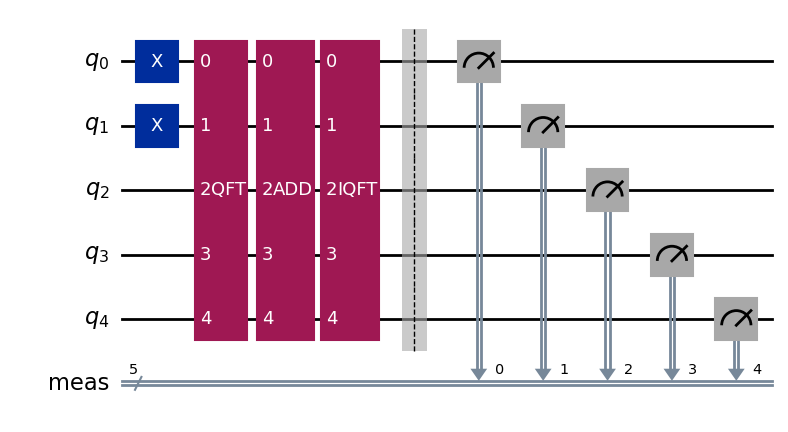

In [7]:
q1 = aplusb(n,a,b)
q1.draw()

In [8]:
tq1 = transpile(q1,simulator)
print(bin(a+b))
print(simulator.run(tq1,shots=100).result().get_counts())

0b101
{'00101': 100}


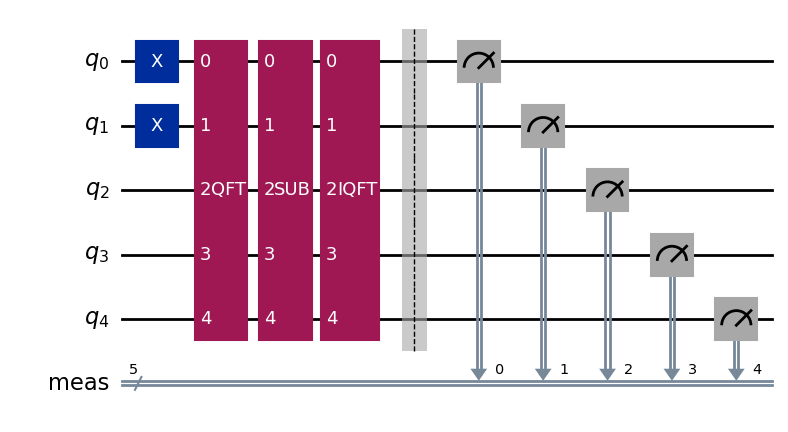

In [9]:
q2 = bminusa(n,a,b)
q2.draw()

In [10]:
tq2 = transpile(q2,simulator)
print(bin((b-a)%2**n))
print(simulator.run(tq2,shots=100).result().get_counts())

0b1
{'00001': 100}


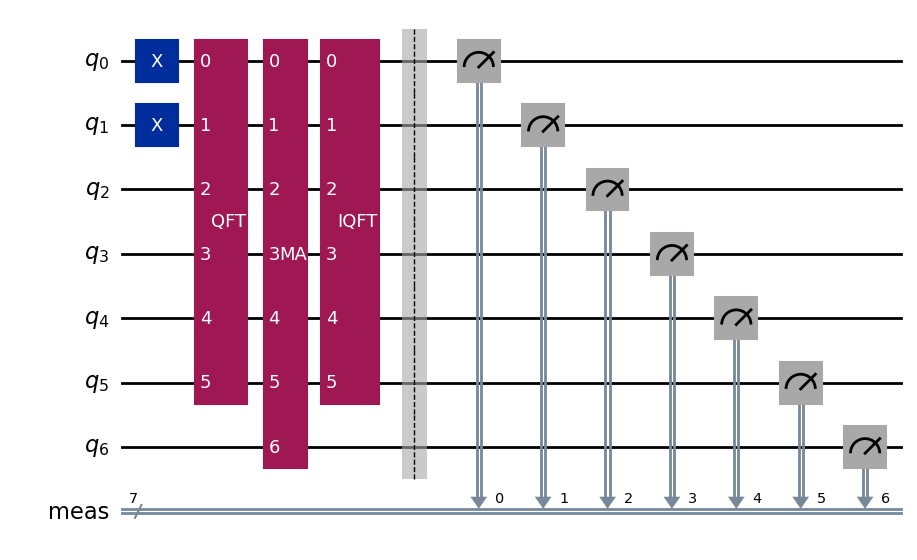

In [13]:
q3 = aplusbmodN(n,a,b,N)
q3.draw()

In [14]:
tq3 = transpile(q3,simulator)
print(bin((b+a)%N))
print(simulator.run(tq3,shots=100).result().get_counts())

0b101
{'0000101': 100}


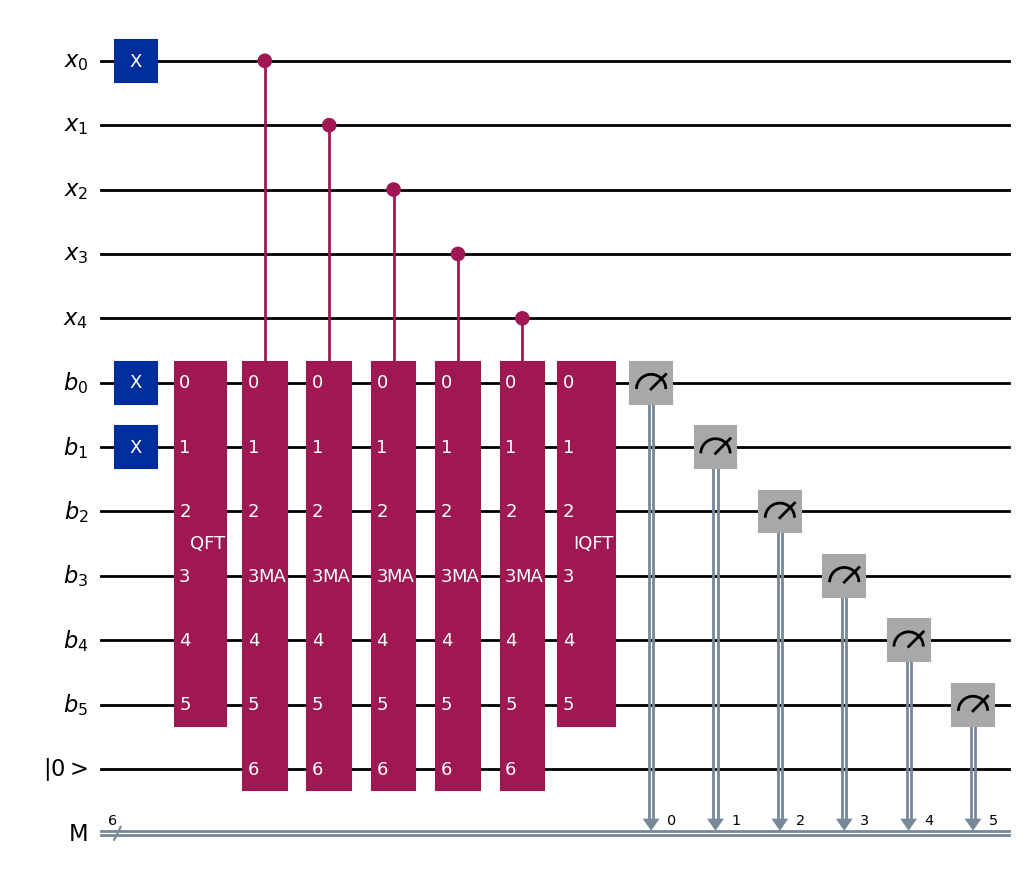

In [19]:
q4 = axplusbmodN(n,a,x,b,N)
q4.draw()

In [20]:
tq4 = transpile(q4,simulator)
print(bin((b+a*x)%N))
print(simulator.run(tq4,shots=100).result().get_counts())

0b101
{'000101': 100}


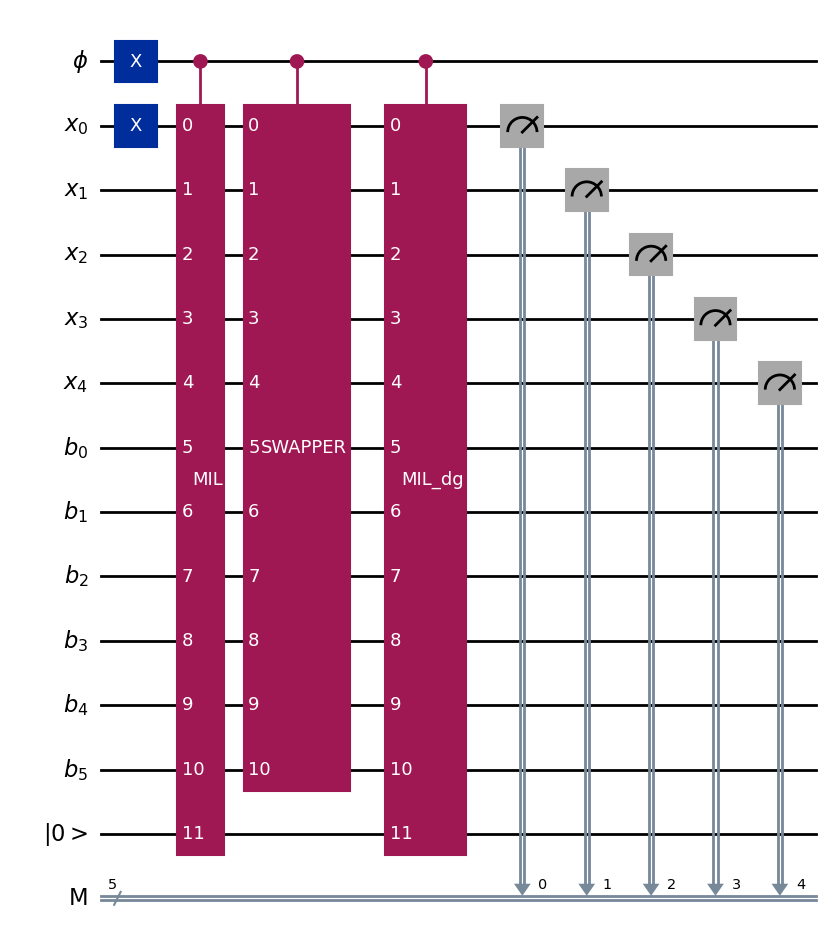

In [35]:
q5 = modexp(n,a,N)
q5.draw()

In [36]:
tq5 = transpile(q5,simulator)
print(simulator.run(tq4,shots=100).result().get_counts())

{'000101': 100}


Testing shor's algorithm

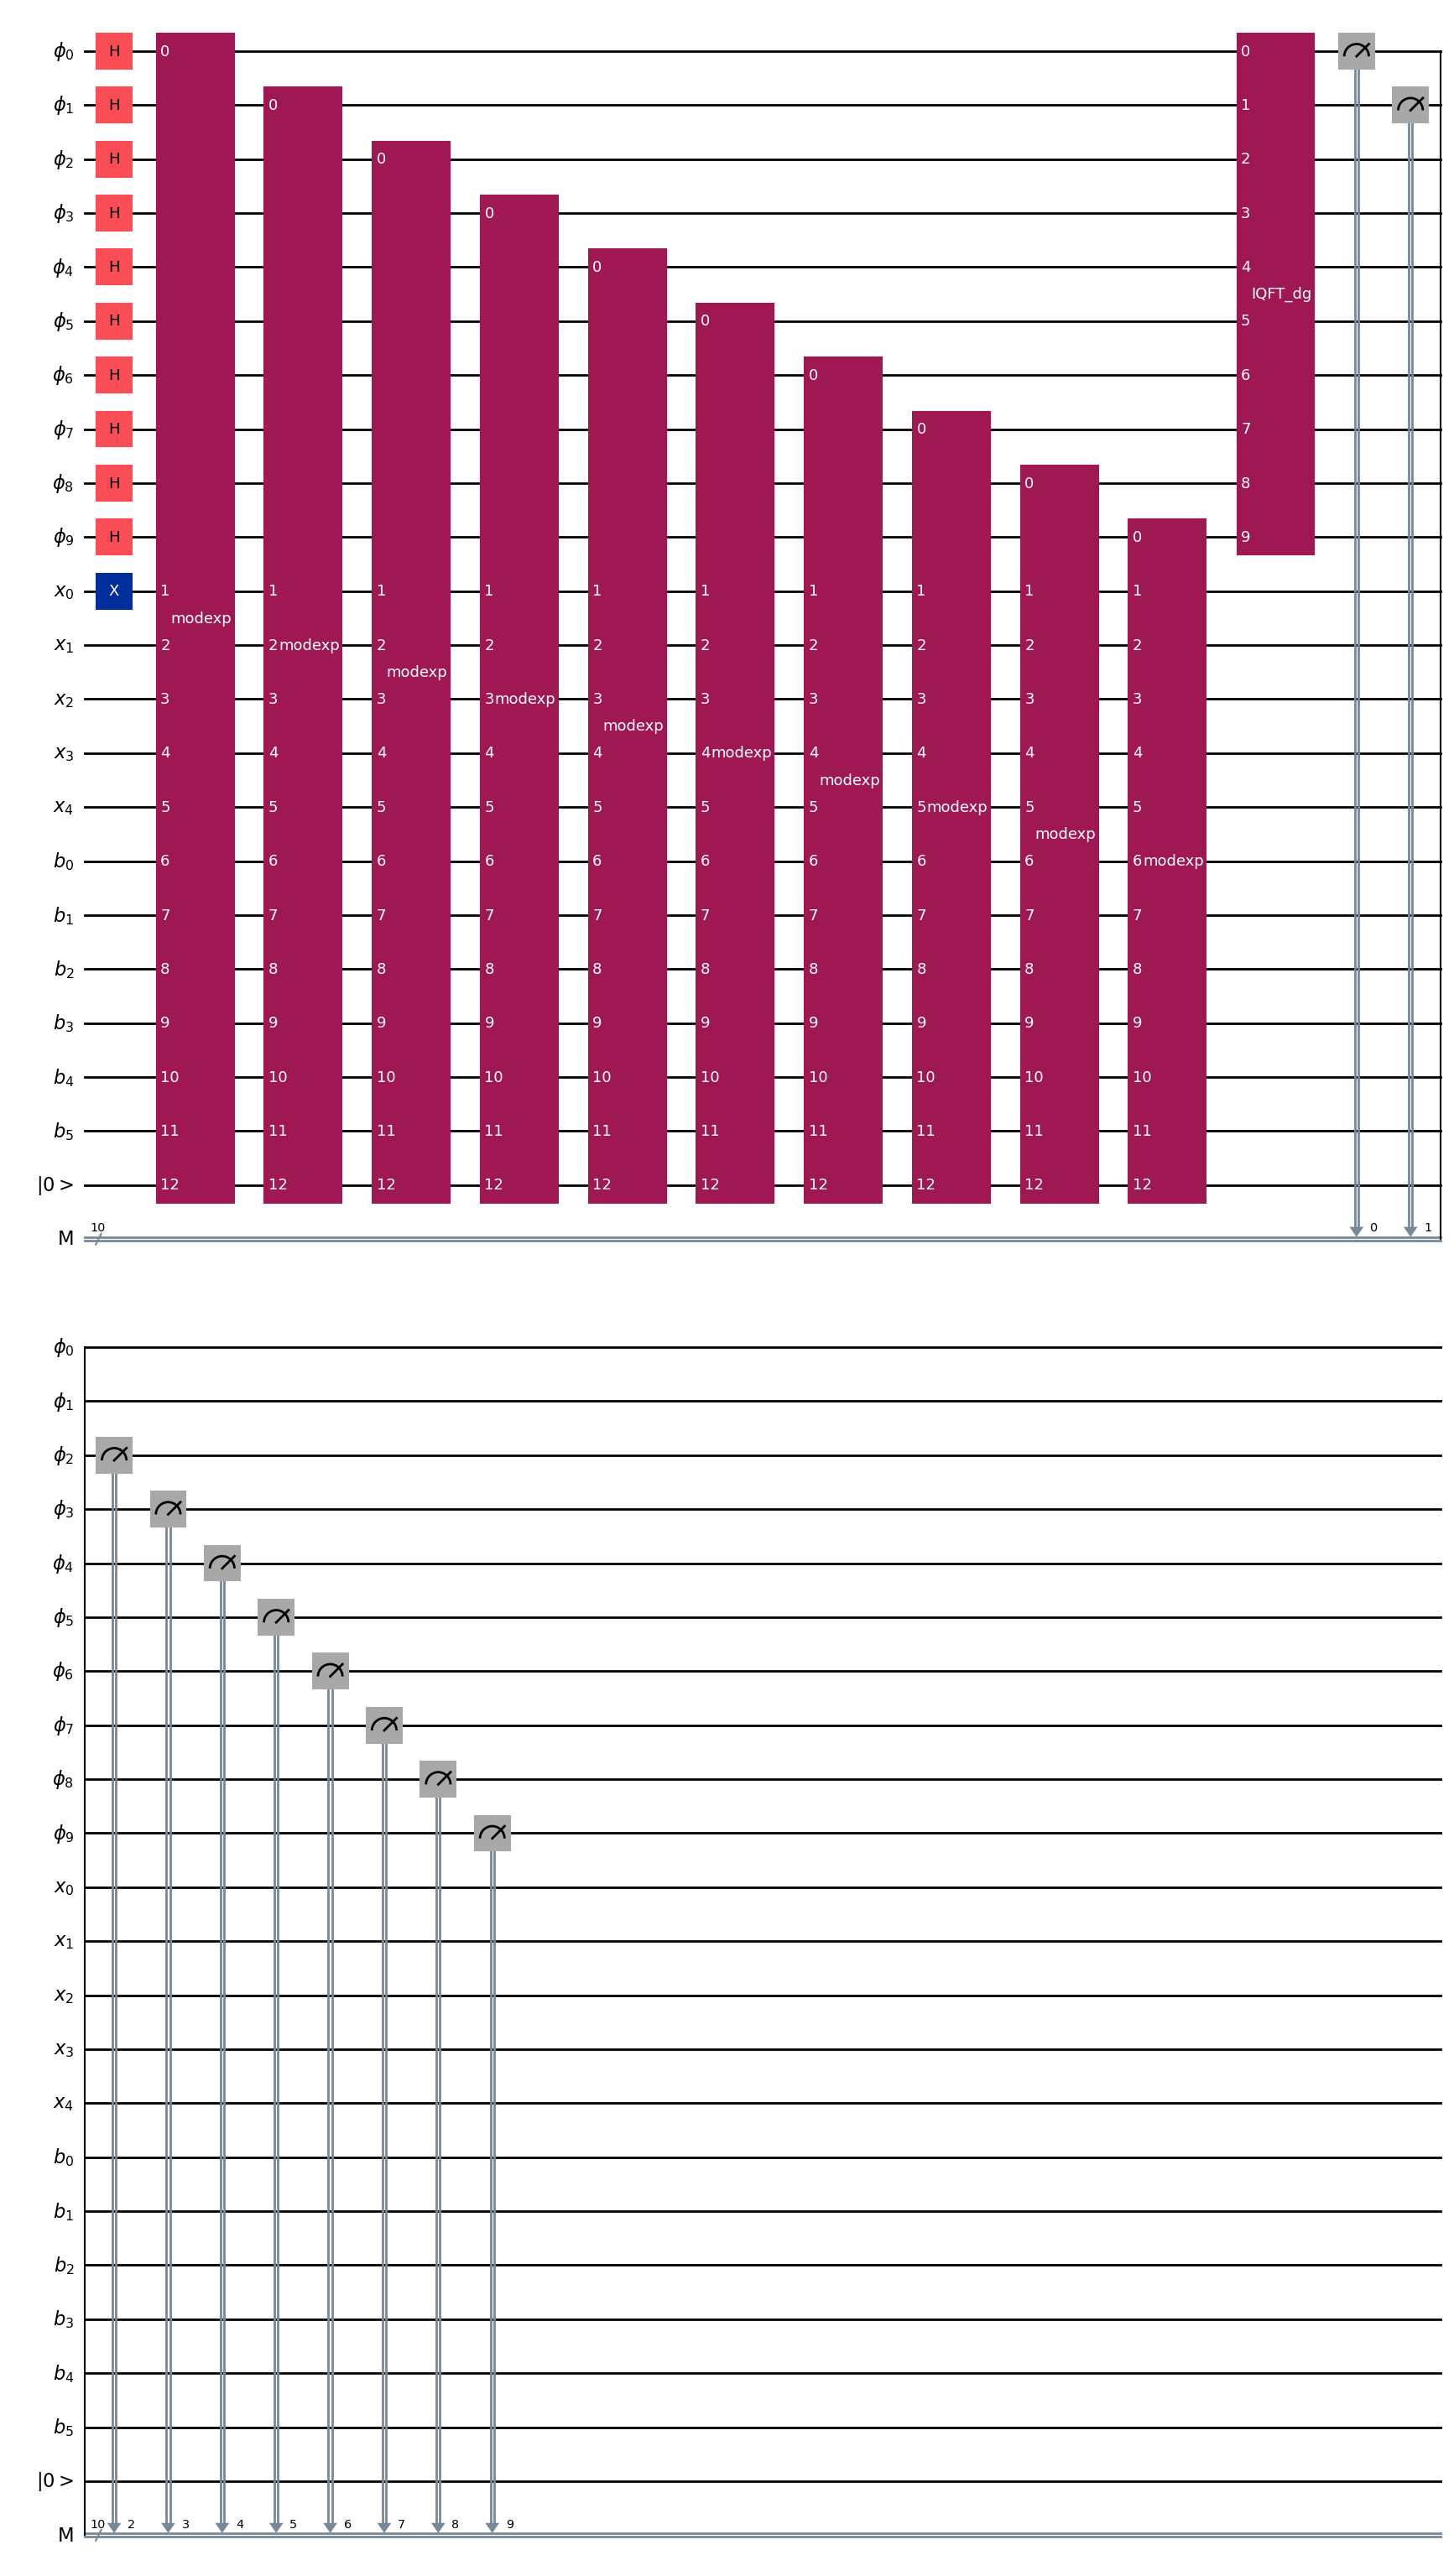

In [7]:
q5 = shor(n,a,N)
q5.draw()

In [8]:
tq5 = transpile(q5,simulator)
print(simulator.run(tq5,shots=1000).result().get_counts())

{'1001011100': 1, '0011111011': 1, '0101010000': 1, '1011011100': 1, '1010110101': 1, '0101001000': 1, '1001111111': 1, '0010111110': 1, '0101001010': 1, '0010100101': 1, '1010000110': 1, '1110111101': 1, '1100101011': 1, '0001011011': 1, '0100101011': 1, '0100110101': 1, '0110001010': 1, '1001100100': 1, '0011000100': 1, '1111100101': 1, '0111010010': 1, '1000010110': 1, '0101001001': 1, '0000111100': 1, '0100011001': 1, '1111111011': 1, '0000011010': 1, '0110011011': 1, '1011010000': 1, '0000001011': 1, '1101010010': 1, '0011001100': 1, '1010000001': 1, '0110111011': 1, '0010100100': 1, '0000011001': 1, '1000001011': 1, '1101011000': 1, '0000101000': 1, '1011110110': 1, '1001011011': 1, '1011111011': 1, '1000111001': 1, '1111011011': 1, '0110100111': 1, '1100110011': 2, '0011010110': 1, '1111010111': 1, '1101111000': 1, '0110100000': 1, '1100110100': 1, '0101011011': 1, '0100110100': 1, '1000000101': 1, '1010101011': 1, '0010001001': 1, '0101010101': 1, '1010101000': 1, '1101011100':

In [ ]:
plot_histogram()

In [1]:
cc = {'1001011100': 1, '0011111011': 1, '0101010000': 1, '1011011100': 1, '1010110101': 1, '0101001000': 1, '1001111111': 1, '0010111110': 1, '0101001010': 1, '0010100101': 1, '1010000110': 1, '1110111101': 1, '1100101011': 1, '0001011011': 1, '0100101011': 1, '0100110101': 1, '0110001010': 1, '1001100100': 1, '0011000100': 1, '1111100101': 1, '0111010010': 1, '1000010110': 1, '0101001001': 1, '0000111100': 1, '0100011001': 1, '1111111011': 1, '0000011010': 1, '0110011011': 1, '1011010000': 1, '0000001011': 1, '1101010010': 1, '0011001100': 1, '1010000001': 1, '0110111011': 1, '0010100100': 1, '0000011001': 1, '1000001011': 1, '1101011000': 1, '0000101000': 1, '1011110110': 1, '1001011011': 1, '1011111011': 1, '1000111001': 1, '1111011011': 1, '0110100111': 1, '1100110011': 2, '0011010110': 1, '1111010111': 1, '1101111000': 1, '0110100000': 1, '1100110100': 1, '0101011011': 1, '0100110100': 1, '1000000101': 1, '1010101011': 1, '0010001001': 1, '0101010101': 1, '1010101000': 1, '1101011100': 1, '1000101011': 1, '1001111010': 1, '1100111000': 1, '0110111010': 1, '1000000110': 1, '1000000111': 1, '1001001111': 1, '1001010101': 1, '0111110110': 2, '0000101010': 2, '0011100000': 1, '1000001100': 1, '1001011000': 1, '1010100101': 1, '1010000011': 1, '0100001010': 1, '0111010110': 1, '1001111011': 1, '0100011011': 1, '0001100100': 1, '0001010100': 1, '1000110100': 1, '0000000100': 1, '1111010101': 1, '1010100010': 1, '0111001111': 1, '0111111111': 1, '1110011010': 1, '1010010000': 1, '0100010110': 1, '0001000100': 1, '0111101111': 1, '1100110010': 1, '1010101100': 1, '0000100001': 1, '1101010011': 1, '1111110100': 1, '1000010101': 1}

In [4]:
len(cc)

97

In [6]:
cc.

KeyError: 1

In [3]:
x=list()
for i in cc:
    for j in cc:
        x[i][j] = np.gcd(i,j)

0.58984375
0.2451171875
0.328125
0.71484375
0.6767578125
0.3203125
0.6240234375
0.185546875
0.322265625
0.1611328125
0.630859375
0.9345703125
0.7919921875
0.0888671875
0.2919921875
0.3017578125
0.384765625
0.59765625
0.19140625
0.9736328125
0.455078125
0.521484375
0.3212890625
0.05859375
0.2744140625
0.9951171875
0.025390625
0.4013671875
0.703125
0.0107421875
0.830078125
0.19921875
0.6259765625
0.4326171875
0.16015625
0.0244140625
0.5107421875
0.8359375
0.0390625
0.740234375
0.5888671875
0.7451171875
0.5556640625
0.9638671875
0.4130859375
0.7998046875
0.208984375
0.9599609375
0.8671875
0.40625
0.80078125
0.3388671875
0.30078125
0.5048828125
0.6669921875
0.1337890625
0.3330078125
0.6640625
0.83984375
0.5419921875
0.619140625
0.8046875
0.431640625
0.505859375
0.5068359375
0.5771484375
0.5830078125
0.490234375
0.041015625
0.21875
0.51171875
0.5859375
0.6611328125
0.6279296875
0.259765625
0.458984375
0.6201171875
0.2763671875
0.09765625
0.08203125
0.55078125
0.00390625
0.9580078125
0.65820

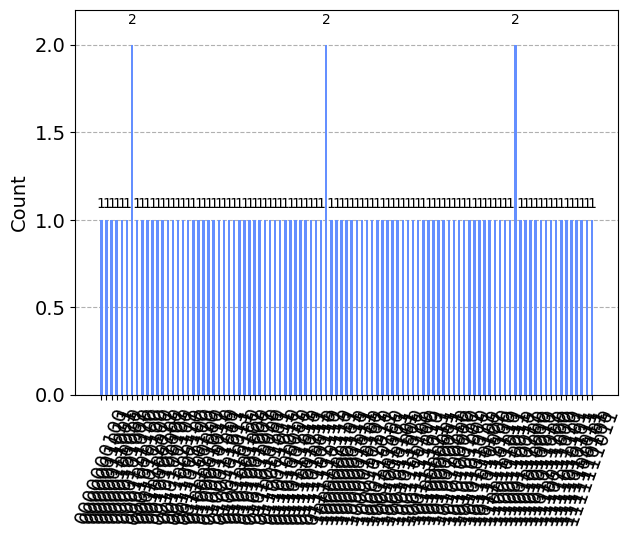

In [12]:
plot_histogram(cc)

In [14]:
def factorize(a,N,counts,tol):
    fs = list()
    for k in counts:
        if counts[k] > tol:
            fs.append(Fraction(int(k,2),2**(2*n)).denominator)
    r = max(Counter(fs), key=Counter(fs).get)
    print('period of ',a,' mod ',N, ' is ' ,r)
    if r%2==0:
        print('1st factor: ',np.gcd(int(a**(r/2) - 1),N))
        print('2nd factor: ',np.gcd(int(a**(r/2) + 1),N))

In [15]:
factorize(a,N,cc,1)

period of  2  mod  21  is  512
1st factor:  1
2nd factor:  1
